In [80]:
import argparse
import os
import sys
from functools import partial
from tqdm import tqdm

# Simulate having cfg available by loading in hydra config as dict
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

import dgl
import dgl.function as fn
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import MeanMetric
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

user_net_id = os.getlogin()
home_path = '/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A'
if home_path not in sys.path:
    sys.path.append('/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A')

from src.datamodules.negative_sampler import NegativeSampler
from src.model.SAGE import SAGE


In [10]:
# Simulate having cfg available by loading in hydra config as dict
from types import SimpleNamespace

class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

cfg = NestedNamespace(yaml.load(open('../conf/config.yaml'), Loader=Loader))

import json
csv_dataset_root = '../' + cfg.data.zillow_root
modal_node_ids = json.load(open(f'{csv_dataset_root}/modal_node_ids.json', 'r'))

## NOTEBOOK ORGANIZATION:
This notebook is for exploring and understanding train_graphsage.py. Given that main() runs train(cfg), where cfg is passed from Hydra, we can explore the notebook by deep diving into each function, class, and procedure that goes into train(). The train() function is provided below, and subsequent cells investigate intermediate outputs of its function calls and other important code blocks.

## Step 1: Exploring DataModule Class

Below we show the DataModule class definition and dependencies, then execute lines of DataModule, step by step, and examine outputs to understand intermediate values and what's going on overall.

In [101]:
def to_bidirected_with_reverse_mapping(g):
    """Makes a graph bidirectional, and returns a mapping array ``mapping`` where ``mapping[i]``
    is the reverse edge of edge ID ``i``. Does not work with graphs that have self-loops.
    """
    g_simple, mapping = dgl.to_simple(
        dgl.add_reverse_edges(g), return_counts="count", writeback_mapping=True
    )
    c = g_simple.edata["count"]
    num_edges = g.num_edges()
    mapping_offset = torch.zeros(g_simple.num_edges() + 1, dtype=g_simple.idtype)
    mapping_offset[1:] = c.cumsum(0)
    idx = mapping.argsort()
    idx_uniq = idx[mapping_offset[:-1]]
    reverse_idx = torch.where(
        idx_uniq >= num_edges, idx_uniq - num_edges, idx_uniq + num_edges
    )
    reverse_mapping = mapping[reverse_idx]
    # sanity check
    src1, dst1 = g_simple.edges()
    src2, dst2 = g_simple.find_edges(reverse_mapping)
    assert torch.equal(src1, dst2)
    assert torch.equal(src2, dst1)
    return g_simple, reverse_mapping

# def exclude_edges(eids, reverse_eids, g, max_img_id, device):
#     src, dst = g.find_edges(eids)
#     eids_exclude = []
#     for i in range(len(eids)):
#         if (src[i]>max_img_id):
#             eids_exclude.append(eids[i])
#     eids_exclude = torch.cat((reverse_eids, torch.Tensor(eids_exclude).type(torch.LongTensor).to(device)))
    
#     return(eids_exclude)

class NegativeSamplerTest(object):
    def __init__(self, g, k, max_img_id, neg_share=False):
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k
        self.neg_share = neg_share
        self.max_img_id = max_img_id

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        img_node_mask = src <= self.max_img_id
        src = src[img_node_mask]
        n = len(src)

        if self.neg_share and n % self.k == 0:
            dst = self.weights.multinomial(n, replacement=True)
            dst = dst.view(-1, 1, self.k).expand(-1, self.k, -1).flatten()
        else:
            dst = self.weights.multinomial(n * self.k, replacement=True)
            
        src = src.repeat_interleave(self.k)
        return src, dst

class DataModule(LightningDataModule):
    def __init__(
        self,
        csv_dataset_root,
        modal_node_ids_file,
        data_cpu=False,
        fan_out=[10, 25],
        device="cpu",
        batch_size=1024,
        num_workers=4,
        force_reload=False,
    ):
        super().__init__()
        self.save_hyperparameters()
        dataset = dgl.data.CSVDataset(csv_dataset_root, force_reload=force_reload)
        g = dataset[0]
        g_bid, reverse_eids = to_bidirected_with_reverse_mapping(g)
        # g = g.formats(["csc"])
        g_bid = g_bid.to(device)
        g = g.to(device)
        reverse_eids = reverse_eids.to(device)
        # seed_edges = torch.arange(g.num_edges()).to(device)

        max_img_id = max(json.load(open(modal_node_ids_file, 'r'))['images'])

        train_nid = torch.nonzero(g_bid.ndata["train_mask"], as_tuple=True)[0].to(device)
        val_nid = torch.nonzero(g_bid.ndata["val_mask"], as_tuple=True)[0].to(device)
        test_nid = torch.nonzero(
            ~(g_bid.ndata["train_mask"] | g_bid.ndata["val_mask"]), as_tuple=True
        )[0].to(device)

        sampler = dgl.dataloading.MultiLayerNeighborSampler(
            [int(_) for _ in fan_out], prefetch_node_feats=["feat"]
        )

        self.g = g
        self.g_bid = g_bid
        self.train_nid, self.val_nid, self.test_nid = train_nid, val_nid, test_nid
        self.sampler = sampler
        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.in_dim = g_bid.ndata["feat"].shape[1]
        self.reverse_eids = reverse_eids
        self.max_img_id = max_img_id


    def train_dataloader(self):
        #exclude_edges_func = partial(exclude_edges, reverse_eids=self.reverse_eids, g=self.g_bid, max_img_id=self.max_img_id, device=self.device)
        
        sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            #exclude=exclude_edges_func,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSampler(self.g, 5, self.max_img_id)
            # negative_sampler=dgl.dataloading.negative_sampler.PerSourceUniform(5),
        )

        return dgl.dataloading.DataLoader(
            self.g_bid,
            self.train_nid,
            sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            # num_workers=self.num_workers,
        )

    def val_dataloader(self):
        #exclude_edges_func = partial(exclude_edges, reverse_eids=self.reverse_eids, g=self.g_bid, max_img_id=self.max_img_id, device=self.device)
        
        sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            #exclude=exclude_edges_func,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSampler(self.g, 3, self.max_img_id)
            # negative_sampler=dgl.dataloading.negative_sampler.PerSourceUniform(5),
        )

        return dgl.dataloading.DataLoader(
            self.g_bid,
            self.val_nid,
            sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            # num_workers=self.num_workers,
        )
    
    def test_dataloader(self):
        sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            #exclude=exclude_edges_func,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSampler(self.g, 2, self.max_img_id)
            # negative_sampler=dgl.dataloading.negative_sampler.PerSourceUniform(5),
        )

        return dgl.dataloading.DataLoader(
            self.g_bid,
            self.test_nid,
            sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            # num_workers=self.num_workers,
        )


In [65]:
# Exploring DataModule class
csv_dataset_root = '../' + cfg.data.zillow_root
force_reload=False
dataset = dgl.data.CSVDataset(csv_dataset_root, force_reload=force_reload)
g = dataset[0]

Done loading data from cached files.


## Step 2: Exploring SAGELightning Class

This is our model that we will train on graph data

In [92]:
class ScorePredictor(nn.Module):
    def forward(self, edge_subgraph, x):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata["h"] = x
            edge_subgraph.apply_edges(fn.u_dot_v("h", "h", "score"))
            return edge_subgraph.edata["score"]


class SAGELightning(LightningModule):
    def __init__(
        self,
        in_dim,
        h_dim,
        n_layers=3,
        activation=F.relu,
        dropout=0,
        sage_conv_method="mean",
        lr=0.0005,
        batch_size=1024,
    ):
        super().__init__()
        self.module = SAGE(
            in_dim, h_dim, n_layers, activation, dropout, sage_conv_method
        )
        self.lr = lr
        self.predictor = ScorePredictor()
        self.batch_size = batch_size
        self.save_hyperparameters() # specify that the module should save hyperparameters on each training loop

        self.train_loss = MeanMetric() # aggregate loss per batch using mean
        self.val_positive_distance = MeanMetric()
        self.val_negative_distance = MeanMetric()

    def forward(self, graph, blocks, x):
        self.module(graph, blocks, x) # Just runs SAGE() model defined in SAGE.py

    def training_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        neg_score = self.predictor(neg_graph, logits)

        score = torch.cat([pos_score, neg_score])
        pos_label = torch.ones_like(pos_score)
        neg_label = torch.zeros_like(neg_score)
        labels = torch.cat([pos_label, neg_label])
        loss = F.binary_cross_entropy_with_logits(score, labels)
        self.train_loss(loss)
        self.log(
            "train_loss",
            self.train_loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
            batch_size=self.batch_size,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        neg_score = self.predictor(neg_graph, logits)

        self.val_positive_distance(pos_score)
        self.val_negative_distance(neg_score)

        self.log(
            "mean_val_posititve_distance",
            self.val_positive_distance,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            batch_size=self.batch_size,
        )
        self.log(
            "mean_val_negative_distance",
            self.val_negative_distance,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            batch_size=self.batch_size,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [93]:
if not torch.cuda.is_available():
    device = "cpu"
else:
    device = "cuda"

In [102]:
modal_node_ids_file = '../'+cfg.data.zillow_root+'/modal_node_ids.json'
datamodule = DataModule(
    '../'+cfg.data.zillow_root, modal_node_ids_file, device=device, batch_size=cfg.training.batch_size
)

model = SAGELightning(
    datamodule.in_dim,
    cfg.model.hidden_dim,
    n_layers=cfg.model.n_layers,
    batch_size=cfg.training.batch_size,
)

checkpoint_callback = ModelCheckpoint(
    monitor="mean_val_negative_distance", save_top_k=1, mode="max"
)
trainer = Trainer(accelerator="gpu", max_epochs=20, callbacks=[checkpoint_callback])

trainer.fit(model, datamodule=datamodule)

Done loading data from cached files.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type           | Params
---------------------------------------------------------
0 | module                | SAGE           | 1.6 M 
1 | predictor             | ScorePredictor | 0     
2 | train_loss            | MeanMetric     | 0     
3 | val_positive_distance | MeanMetric     | 0     
4 | val_negative_distance | MeanMetric     | 0     
---------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.298     Total estimated model params size (MB)


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:135: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` 

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 71/71 [00:01<00:00, 53.91it/s, loss=0.664, v_num=15, train_loss=0.665, mean_val_posititve_distance=0.789, mean_val_negative_distance=0.0449] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 71/71 [00:01<00:00, 53.82it/s, loss=0.664, v_num=15, train_loss=0.665, mean_val_posititve_distance=0.789, mean_val_negative_distance=0.0449]


In [88]:
modal_node_ids_file = '../'+cfg.data.zillow_root+'/modal_node_ids.json'
datamodule = DataModule(
    '../'+cfg.data.zillow_root, modal_node_ids_file, device=device, batch_size=cfg.training.batch_size
)
val_dataloader = datamodule.val_dataloader()

Done loading data from cached files.


In [89]:
i = 0
end = 58
max_img_id = max(modal_node_ids['images'])
min_kw_id = min(modal_node_ids['keywords'])

same_node_connect_pos_subgraph = []
same_node_connect_neg_subgraph = []

for batch in val_dataloader:
    input_nodes, pos_graph, neg_graph, blocks = batch
    pos_mapper = dict(zip(pos_graph.nodes().detach().cpu().numpy(), 
                pos_graph.ndata['_ID'].detach().cpu().numpy()))

    neg_mapper = dict(zip(neg_graph.nodes().detach().cpu().numpy(), 
                neg_graph.ndata['_ID'].detach().cpu().numpy()))

    src_pos, dst_pos = [x.detach().cpu().numpy() for x in pos_graph.edges()]
    src_neg, dst_neg = [x.detach().cpu().numpy() for x in neg_graph.edges()]
    
    src_pos = [pos_mapper[src] for src in src_pos]
    dst_pos = [pos_mapper[dst] for dst in dst_pos]

    src_neg = [neg_mapper[src] for src in src_neg]
    dst_neg = [neg_mapper[dst] for dst in dst_neg]

    src_dst_pos, src_dst_neg = list(zip(src_pos, dst_pos)), list(zip(src_neg, dst_neg))

    for pair in src_dst_pos:
        if (pair[0]<max_img_id and pair[1]<max_img_id) or (pair[0]>min_kw_id and pair[1]>min_kw_id):
            same_node_connect_pos_subgraph.append(pair)
    
    for pair in src_dst_neg:
        if (pair[0]<max_img_id and pair[1]<max_img_id) or (pair[0]>min_kw_id and pair[1]>min_kw_id):
            same_node_connect_neg_subgraph.append(pair)
    
    i += 1
    if i == end:
        break

print(len(same_node_connect_pos_subgraph))
print(len(same_node_connect_neg_subgraph))
print(len(src_dst_pos))
print(len(src_dst_neg))

0
0
383
1355


## UMAP Plotting

In [103]:
# This cell grabs a sample of 10 edges and gets feature embeddings for incident nodes before ('feat') and after ('h') graphSAGE updates

test_dataloader = datamodule.test_dataloader()
new_old_node_id_mapping = json.load(open(f'../{cfg.data.zillow_root}/new_old_node_id_mapping.json', 'r'))

for batch in test_dataloader:
    inputs, pos_graph, neg_graph, blocks = batch
    pos_mapper = dict(zip(pos_graph.nodes().detach().cpu().numpy(), 
                pos_graph.ndata['_ID'].detach().cpu().numpy()))
    
    # update pos_graph node embeddings
    blocks = [block.to(device) for block in blocks]
    model = model.to(device)
    x = blocks[0].srcdata["feat"]
    logits = model.module(blocks, x)
    pos_graph.ndata["h"] = logits

    src_premap, dst_premap = [x.detach().cpu().numpy() for x in pos_graph.edges()]
    src = [pos_mapper[x] for x in src_premap]
    dst = [pos_mapper[x] for x in dst_premap]
    nodes = [pos_mapper[x] for x in pos_graph.nodes().detach().cpu().tolist()]

    sample_size = 10
    sample_src = src[:sample_size]
    sample_dst = dst[:sample_size]

    src_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_src]).to(device)
    dst_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_dst]).to(device)


    # Embeddings of source and destination nodes in positive graph before and after GraphSAGE updates
    sample_src_embeds_pre = pos_graph.ndata['feat'][src_node_indices]
    sample_dst_embeds_pre = pos_graph.ndata['feat'][dst_node_indices]
    sample_src_embeds_post = pos_graph.ndata['h'][src_node_indices]
    sample_dst_embeds_post = pos_graph.ndata['h'][dst_node_indices]

    break

In [104]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [105]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, pair_ids, title):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(5,5))

    plt.scatter(reduced[:, 0], reduced[:, 1], c=pair_ids)
    for i, pair_id in enumerate(pair_ids):
        current_point = reduced[i]
        plt.annotate(pair_ids[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.title(title)
    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


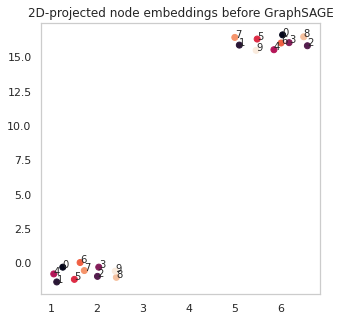

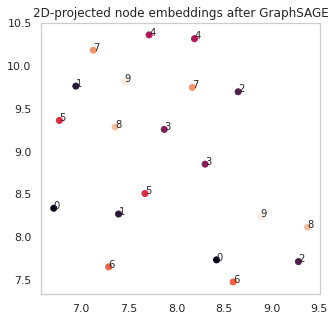

In [106]:
# Plot 2D projections of node embeddings from 10 sampled edges before and after graphSAGE updates

pair_ids = list(range(sample_src_embeds_pre.size(0)))*2
weight_matrix_pre = torch.cat((sample_src_embeds_pre, sample_dst_embeds_pre))
weight_matrix_post = torch.cat((sample_src_embeds_post, sample_dst_embeds_post))

umap_plot(weight_matrix_pre, pair_ids, title='2D-projected node embeddings before GraphSAGE')
umap_plot(weight_matrix_post, pair_ids, title='2D-projected node embeddings after GraphSAGE')

In [109]:
# For 10 samples, get pct change in pairwise cosine similarity for true src-dst pairs and negative pairs

import pandas as pd
from sklearn import metrics

cos_similarities = pd.DataFrame()

pre_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_pre.cpu().detach().numpy(), sample_dst_embeds_pre.cpu().detach().numpy())
post_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_post.cpu().detach().numpy(), sample_dst_embeds_post.cpu().detach().numpy())

for i in range(pre_sims.shape[0]):
    src_dst_sim_pre = pre_sims[i,i]
    non_pair_sims_pre = np.sum(np.concatenate((pre_sims[i,:i],pre_sims[i,i+1:]))) / (len(pre_sims[i])-1)

    src_dst_sim_post = post_sims[i,i]
    non_pair_sims_pos = np.sum(np.concatenate((post_sims[i,:i],post_sims[i,i+1:]))) / (len(post_sims[i])-1)

    cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                   'src_dst_sim_CLIP': src_dst_sim_pre,
                                                                   'non_pair_sim_CLIP': non_pair_sims_pre,
                                                                   'src_dst_sim_SAGE': src_dst_sim_post,
                                                                   'non_pair_sim_SAGE': non_pair_sims_pos}])])
cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['non-pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100

cos_similarities

,pair_id,src_dst_sim_CLIP,non_pair_sim_CLIP,src_dst_sim_SAGE,non_pair_sim_SAGE,pair similarity change,non-pair similarity change
0,0,0.404855,0.688261,0.561160,0.057893,38.607727,-91.588545
1,1,0.436929,0.549036,0.000000,0.094273,-100.000000,-82.829312
2,2,0.407360,0.568621,0.000000,0.284938,-100.000000,-49.889582
3,3,0.440279,0.542635,0.755267,0.140376,71.542778,-74.130744
4,4,0.409799,0.538657,0.593837,0.064267,44.909576,-88.069074
5,5,0.423925,0.546162,0.000000,0.089577,-100.000000,-83.598783
6,6,0.402524,0.692793,0.361423,0.048716,-10.210768,-92.968148
7,7,0.397216,0.667734,0.000000,0.060076,-100.000000,-91.002943
8,8,0.417009,0.564513,0.286131,0.232500,-31.384859,-58.814134
9,9,0.410430,0.691050,0.000000,0.220335,-100.000000,-68.115842


In [70]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 288 kB 24.4 MB/s eta 0:00:01


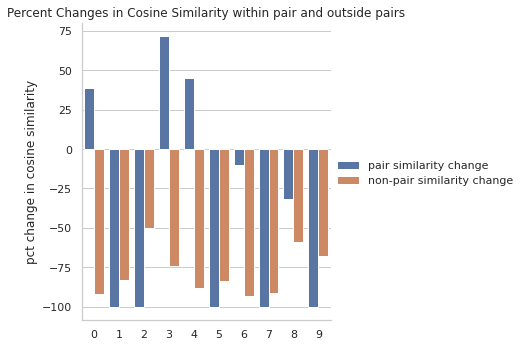

Average pair similarity change: -38.653557
Average non-pair similarity change: -78.10071075362406


In [108]:
import seaborn as sns
sns.set_theme(style='whitegrid')
cos_similarities_tp = pd.melt(cos_similarities, id_vars='pair_id', value_vars=['pair similarity change', 'non-pair similarity change'])

g = sns.catplot(data=cos_similarities_tp, kind='bar', x='pair_id', y='value', hue='variable', errorbar='sd')

g.set_axis_labels('', 'pct change in cosine similarity')
g.legend.set_title('')
plt.title('Percent Changes in Cosine Similarity within pair and outside pairs')
plt.show()

print('Average pair similarity change:', cos_similarities['pair similarity change'].mean())
print('Average non-pair similarity change:', cos_similarities['non-pair similarity change'].mean())


In [100]:
# Run the same analysis as above for all edges in the test dataset and compute average change in cosine similarity for positive pairs and negative pairs

test_dataloader = datamodule.test_dataloader()
val_dataloader = datamodule.val_dataloader()
new_old_node_id_mapping = json.load(open(f'../{cfg.data.zillow_root}/new_old_node_id_mapping.json', 'r'))
cos_similarities = pd.DataFrame()

for batch in tqdm(val_dataloader, desc='computing pre-post cosine sims'):
    inputs, pos_graph, neg_graph, blocks = batch
    pos_mapper = dict(zip(pos_graph.nodes().detach().cpu().numpy(), 
                pos_graph.ndata['_ID'].detach().cpu().numpy()))
    
    # update pos_graph node embeddings
    blocks = [block.to(device) for block in blocks]
    model = model.to(device)
    x = blocks[0].srcdata["feat"]
    logits = model.module(blocks, x)
    pos_graph.ndata["h"] = logits

    src_premap, dst_premap = [x.detach().cpu().numpy() for x in pos_graph.edges()]
    src = [pos_mapper[x] for x in src_premap]
    dst = [pos_mapper[x] for x in dst_premap]
    nodes = [pos_mapper[x] for x in pos_graph.nodes().detach().cpu().tolist()]

    sample_size = 10
    sample_src = src[:sample_size]
    sample_dst = dst[:sample_size]

    src_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_src]).to(device)
    dst_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_dst]).to(device)


    # Embeddings of source and destination nodes in positive graph before and after GraphSAGE updates
    sample_src_embeds_pre = pos_graph.ndata['feat'][src_node_indices]
    sample_dst_embeds_pre = pos_graph.ndata['feat'][dst_node_indices]
    sample_src_embeds_post = pos_graph.ndata['h'][src_node_indices]
    sample_dst_embeds_post = pos_graph.ndata['h'][dst_node_indices]

    pre_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_pre.cpu().detach().numpy(), sample_dst_embeds_pre.cpu().detach().numpy())
    post_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_post.cpu().detach().numpy(), sample_dst_embeds_post.cpu().detach().numpy())

    for i in range(pre_sims.shape[0]):
        src_dst_sim_pre = pre_sims[i,i]
        non_pair_sims_pre = np.sum(np.concatenate((pre_sims[i,:i],pre_sims[i,i+1:]))) / (len(pre_sims[i])-1)

        src_dst_sim_post = post_sims[i,i]
        non_pair_sims_pos = np.sum(np.concatenate((post_sims[i,:i],post_sims[i,i+1:]))) / (len(post_sims[i])-1)

        cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                    'src_dst_sim_CLIP': src_dst_sim_pre,
                                                                    'non_pair_sim_CLIP': non_pair_sims_pre,
                                                                    'src_dst_sim_SAGE': src_dst_sim_post,
                                                                    'non_pair_sim_SAGE': non_pair_sims_pos}])])

cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['non-pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100

cos_similarities.head()
print('Average pair similarity change:', cos_similarities['pair similarity change'].mean())
print('Average non-pair similarity change:', cos_similarities['non-pair similarity change'].mean())

computing pre-post cosine sims: 100%|██████████| 13/13 [00:00<00:00, 48.31it/s]

Average pair similarity change: -36.124657
Average non-pair similarity change: -74.51740947307698
